# COPD staging using deep learning (LSTM-CNN)

The goal of this project is to build a neural network model capable of diagnosing COPD given a thoracic CT scan. We will use tensorflow to build the model, which will be trained and validated on the COPDGene database. <br><br>
This project is based on the paper ["Disease staging and prognosis in smokers using deep learning in chest computed tomography"](https://pubmed.ncbi.nlm.nih.gov/28892454/) by Germán González et al., in which a CNN is deployed to detect and stage COPD as well as to predict ARD and mortality in smokers. They use a composite 2D image of 4 chest CT slices, which are retrieved using an automated structures detection algorithm. In our proyect, we will use the whole CT scan to diagnose and stage COPD, using the method developed in Stephen M. Humphries et al.'s paper ["Deep learning enables automatic classifiaction of emphysema pattern at CT"](https://pubmed.ncbi.nlm.nih.gov/31793851/), which combines a LSTM neural network with a CNN. The purpose of doing so is to be able to stage COPD in one single step, making the process faster and more reliable, as the structures detection algorithm can sometimes err and the CT slices obtained from it are not the expected ones.

First, we have to import the python libraries that we are going to need for the project.

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import tensorflow        as tf

import h5py
import os

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.python.keras.models    import Model
from tensorflow.python.keras.layers    import *
from tensorflow.python.keras.losses    import *
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers       import *

## 1. Loading and preprocessing the data:

We already have an .h5 file with the raw data that we need for our problem. This file contains axial CT scans from COPDGene (along with their UID) and their associated GOLD score. The scans were all processed so that they all have 20 equidistant slices with the same dimensions. The GOLD scores are integer numbers ranging from 0 (normal) to 4 (severe COPD).

In [2]:
h5_file = "/home/mi927/Projects/2020 - 2022/2021_Mar_BDCatalyst/copd_staging_deeplearning/copd_staging_dataset.h5"

with h5py.File(h5_file, 'r') as h5f:    
    # Printing all the datasets stored in the .h5 file:
    print('List of datasets stored in %s:' % (h5_file)) 
    for k in h5f.keys():
        print('- ', k) 

List of datasets stored in /home/mi927/Projects/2020 - 2022/2021_Mar_BDCatalyst/copd_staging_deeplearning/copd_staging_dataset.h5:
-  Axial_CT
-  Axial_CT.key
-  FinalGold


We can visualize some of the data by loading it into memory:

Total number of CTs:         5731
Total number of GOLD scores: 5731

GOLD values: [0. 1. 2. 3. 4.]

Axial CT dimensions: (5731, 20, 512, 512)
Axial CT intensity range: [-3024 , 3071]


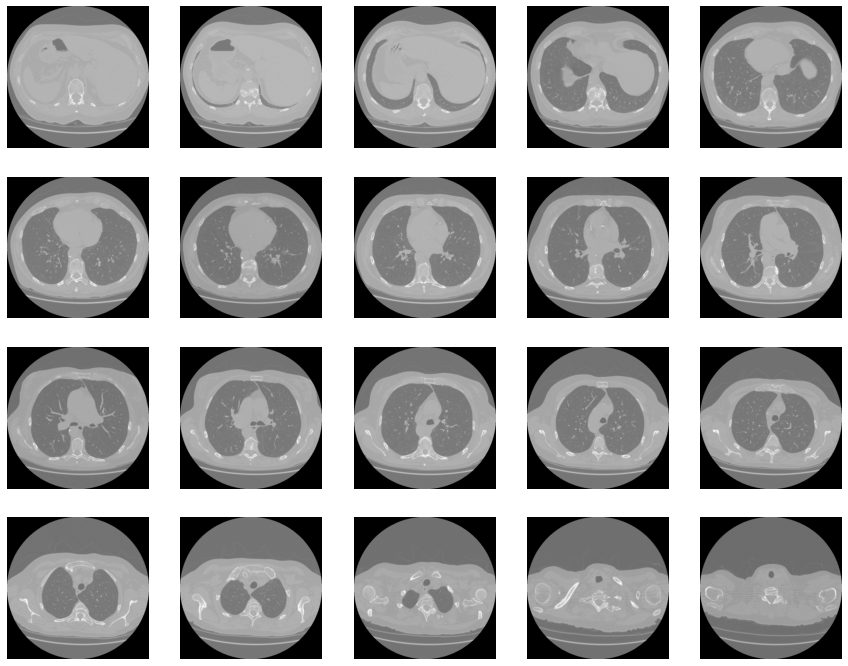

In [3]:
with h5py.File(h5_file, 'r') as h5f:  
    # Retrieving the total number of samples in the .h5 file:
    total_img  = len(h5f.get('Axial_CT'))   h5f['Axial_CT'][ii:ii+5]
    total_gold = len(h5f.get('FinalGold')) 
    print('Total number of CTs:        ', total_img) 
    print('Total number of GOLD scores:', total_gold) 
    print('') 
    
    # Printing the FinalGold possible values:
    print('GOLD values:', np.sort(np.unique(h5f.get('FinalGold')))) 
    print('') 
    
    # Printing the Axial_CT dimensions and intensity range:
    print('Axial CT dimensions:', np.shape(h5f.get('Axial_CT'))) 
    print('Axial CT intensity range: [%d , %d]' % (np.min(h5f.get('Axial_CT')[:100]), np.max(h5f.get('Axial_CT')[:100]))) 
    
    # Displaying a sample CT volume:
    img = h5f.get('Axial_CT')[5] 
    # as we know that each CT is composed of 20 equidistant slices, we can display them sequentially:
    cnt = 0
    plt.figure(figsize=(15,12)) 
    for row in np.arange(1,5):
        for col in np.arange(1,6):
            plt.subplot(4,5,cnt+1) 
            plt.axis('off') 
            plt.imshow(img[cnt,:,:], cmap='gray') 
            cnt += 1
    plt.show() 

Convolutional neural networks generally work better when the input data is normalized (so that the intensity range of the images is [0, 1]). We also want to change the window level and width to fit the values used to [visualize COPD on CTs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4613878/). 

Original CT:
* Min value: -3024.0
* Max value:  1741.0


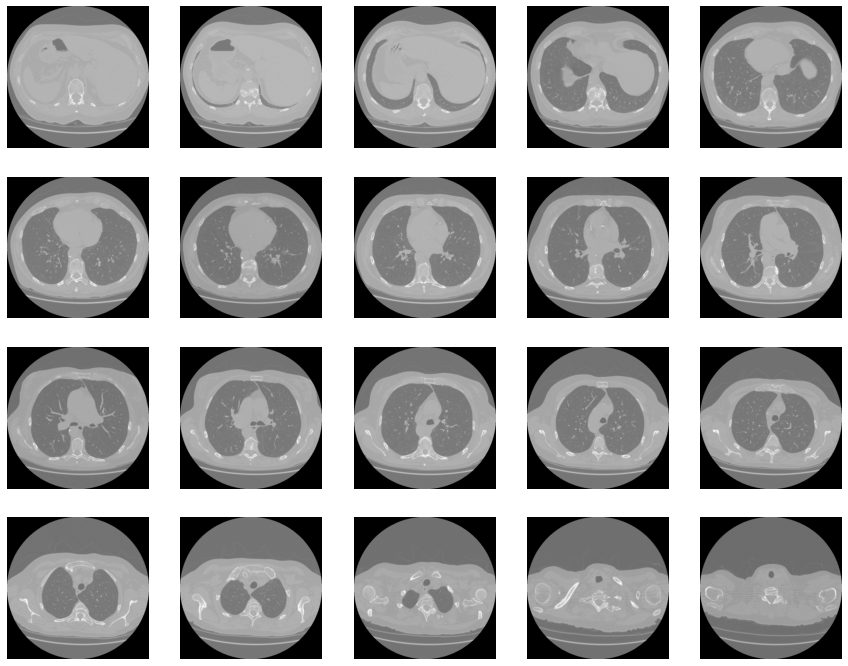

Processed CT:
* Min value: 0.0
* Max value: 1.0


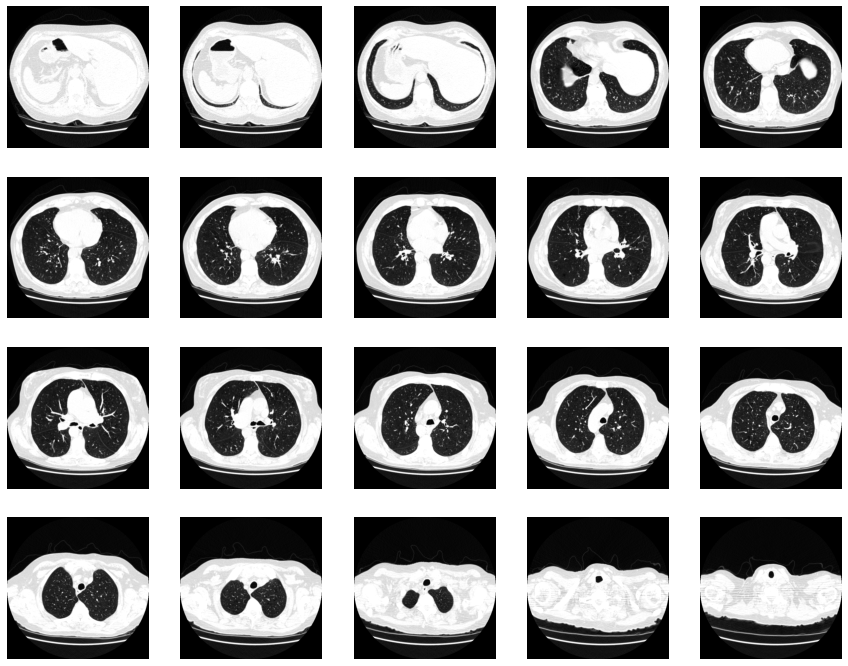

In [4]:
min_val = -1024
max_val =    50

with h5py.File(h5_file, 'r') as h5f:  
    # Displaying a sample CT volume:
    img = h5f.get('Axial_CT')[5] 
    print('Original CT:') 
    print('* Min value:',  np.min(img)) 
    print('* Max value: ', np.max(img))
    cnt = 0
    plt.figure(figsize=(15,12)) 
    for row in np.arange(1,5):
        for col in np.arange(1,6):
            plt.subplot(4,5,cnt+1) 
            plt.axis('off') 
            plt.imshow(img[cnt,:,:], cmap='gray') 
            cnt += 1
    plt.show() 
    
    # Clipp the max an min values to the COPD visualization window:
    img[img<min_val] = min_val
    img[img>max_val] = max_val
    # Normalize the intensities:
    img -= min_val
    img /= (max_val - min_val) 
    
    #Display the post-processed CT volume:
    print('Processed CT:') 
    print('* Min value:', np.min(img)) 
    print('* Max value:', np.max(img))
    cnt = 0
    plt.figure(figsize=(15,12)) 
    for row in np.arange(1,5):
        for col in np.arange(1,6):
            plt.subplot(4,5,cnt+1) 
            plt.axis('off') 
            plt.imshow(img[cnt,:,:], cmap='gray') 
            cnt += 1
    plt.show() 

Lastly, we want to add the channels dimension to the scans, as this information is needed when using deep learning. RGB (color) images have 3 channels, while grayscale images have only 1 channel. We will therefore add a single channel (dimension) to each of our CT scans.

In [5]:
# Adding the channels dimension to the volume:
print('Original CT shape:', img.shape) 
img = np.expand_dims(img, -1) 
print('New CT shape:     ', img.shape) 

Original CT shape: (20, 512, 512)
New CT shape:      (20, 512, 512, 1)


The labels (GOLD scores) are already in the format we need them, so we do not need to do any procesing on them.

Below you can see a snippet of the code used to create the .h5 with the processed CT scans as described in this section:

``` js 
out_h5  = 'BDSubmission_COPDStaging_processedData.h5'

# Create a new .h5 file to store our training and testing data:
ff = h5py.File(out_h5, 'w') 
X = ff.create_dataset("Axial_CT",     (total_img,) + input_shape, dtype='float32') 
y = ff.create_dataset("FinalGold",    (total_img,),               dtype='float32') 
k = ff.create_dataset("Axial_CT.key", (total_img, 2),             dtype=h5py.special_dtype(vlen=str)) 

# Populate the new .h5 with data:
print('Adding data to the new .h5 file...') 
with h5py.File(h5_file, 'r') as h5f:
    for ii in np.arange(0, total_img):
        # Load a single data point of each dataframe from the original .h5:
        img   = h5f.get('Axial_CT')[ii] 
        key   = h5f.get('Axial_CT.key')[ii] 
        score = h5f.get('FinalGold')[ii]   
        # Process the image data (CT scan):
        min_val = -1024
        max_val =    50
        img[img<min_val] = min_val
        img[img>max_val] = max_val
        img -= min_val
        img /= (max_val - min_val) 
        # Save the processed CT scan and its key and gold score into the new .h5 file:
        X[ii] = img
        k[ii] = key
        y[ii] = score

print('New .h5 created and fully populated with data.')       
```

## 2. Building the network:

We want to build a 2D CNN capable of reading the CT volume in order to calculate the GOLD score of any given subject. To do this, we will combine a standard image CNN with a LSTM network. This will allow us to process each CT slice as a 2D image, to then sequentially analyze the features extracted from each slice to obtain a final global GOLD score.

We will follow the architecture described in Figure 1 in the article [Deep Learning Enables Automatic Classification of Emphysema Pattern at CT](https://pubmed.ncbi.nlm.nih.gov/31793851/), using Keras to build the model. 

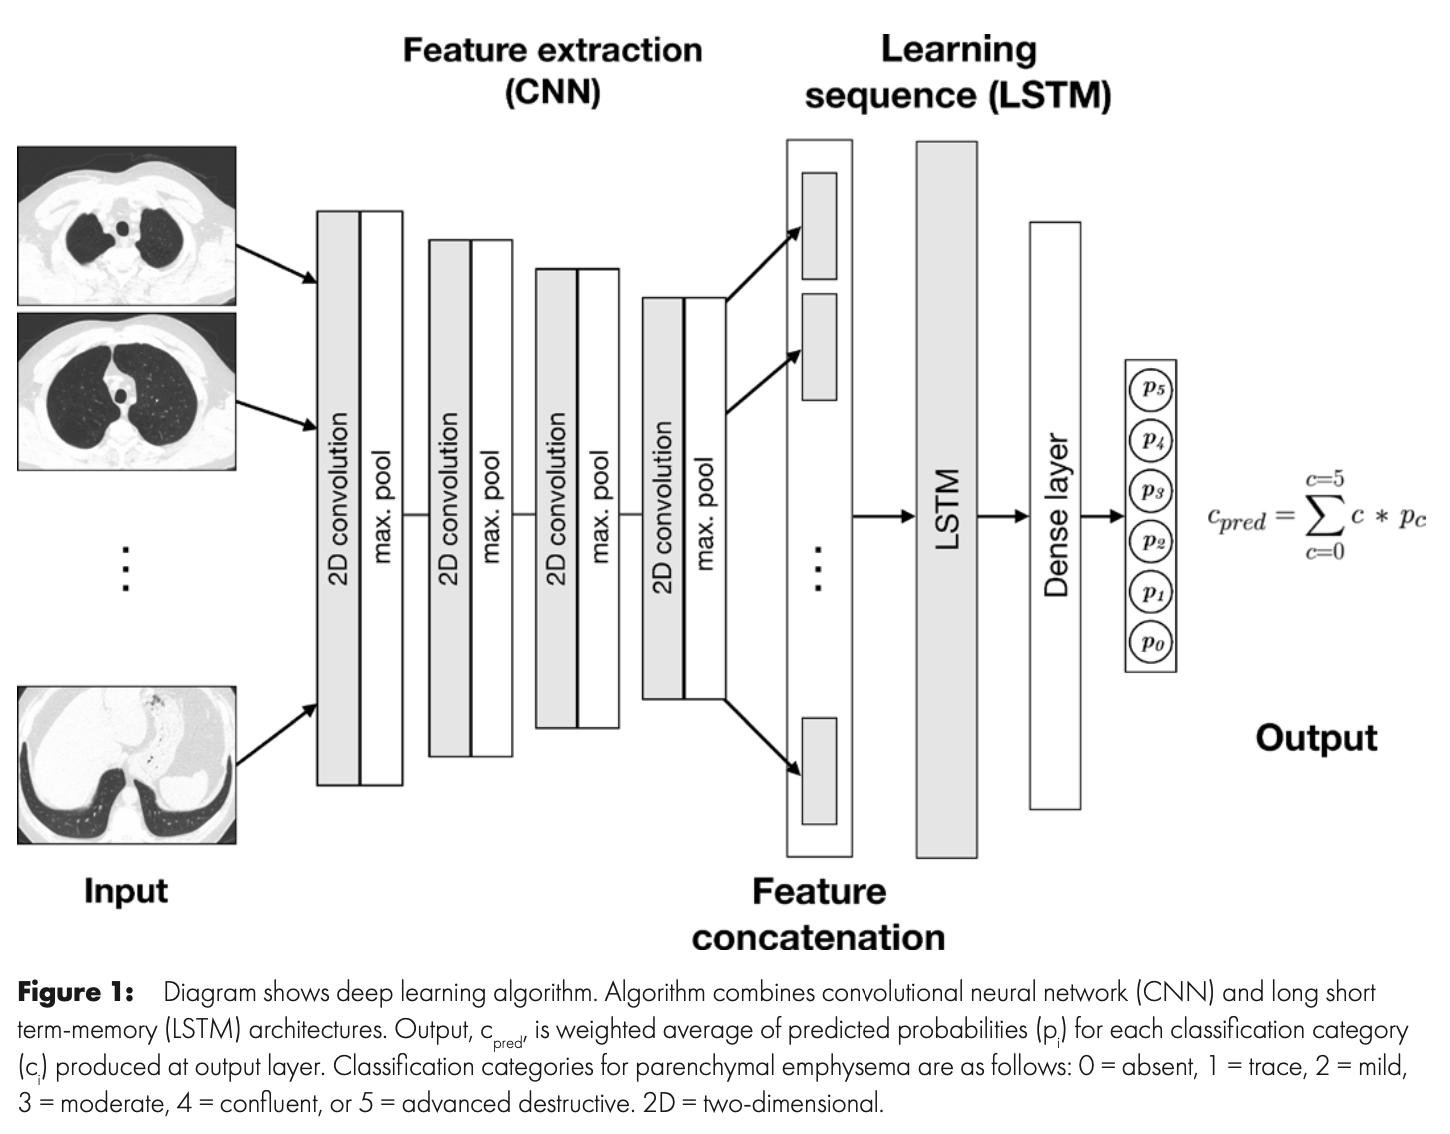

In [2]:
def build_model(image_dims, n_slices): 
    # First, build the 2D CNN model:
    ipt = Input(shape=image_dims,              name='CNN_Input') 
    x = Conv2D(32, (6, 6), activation='relu',  name='Conv2D_1')(ipt) 
    x = MaxPooling2D(pool_size=(3, 3),         name='MaxPooling2D_1')(x) 
    x = Conv2D(96, (3, 3), activation='relu',  name='Conv2D_2')(x) 
    x = MaxPooling2D(pool_size=(3, 3),         name='MaxPooling2D_2')(x) 
    x = Conv2D(256, (3, 3), activation='relu', name='Conv2D_3')(x) 
    x = MaxPooling2D(pool_size=(4, 4),         name='MaxPooling2D_3')(x) 
    x = Conv2D(384, (3, 3), activation='relu', name='Conv2D_4')(x) 
    x = MaxPooling2D(pool_size=(4, 4),         name='MaxPooling2D_4')(x) 
    x = Flatten(                               name='Flatten')(x) 
    
    cnn = Model(inputs=ipt, outputs=x, name='cnn') 
    
    # Then, wrap the whole CNN into a LSTM framework:
    lstm_input_shape = (n_slices,) + image_dims
    lstm_in = Input(shape=lstm_input_shape, name='Input') 
    x   = TimeDistributed(cnn,              name='TimeDistributedFeatures')(lstm_in) 
    x   = LSTM(1228,                        name='LSTM')(x) 
    x   = Dropout(0.5,                      name='Dropout')(x) 
    x   = Dense(1024, activation='relu',    name='Dense_1')(x) 
    opt = Dense(5, activation='softmax',    name='Output')(x) 
    
    final_model = Model(inputs=lstm_in, outputs=opt, name='CNN-LSTM') 
    
    return final_model

The CNN part of the model is a simple network composed of 4 convolutional layers, each followed by a max pooling layer, which are then flattened out into a 1D tensor. <br>
The LSTM portion of the network gathers the outputs of the CNN network and passes them to a LSTM layer. The output layer has 5 neurons, as we are working on a 5-label classification problem (each label corresponds to a GOLD score, from 0 to 4).

We can visualize the architecture of our model by either printing the keras summary, or by plotting it:

Model: "CNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 20, 512, 512, 1)] 0         
_________________________________________________________________
TimeDistributedFeatures (Tim (None, 20, 1536)          1135488   
_________________________________________________________________
LSTM (LSTM)                  (None, 1228)              13581680  
_________________________________________________________________
Dropout (Dropout)            (None, 1228)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 1024)              1258496   
_________________________________________________________________
Output (Dense)               (None, 5)                 5125      
Total params: 15,980,789
Trainable params: 15,980,789
Non-trainable params: 0
______________________________________________

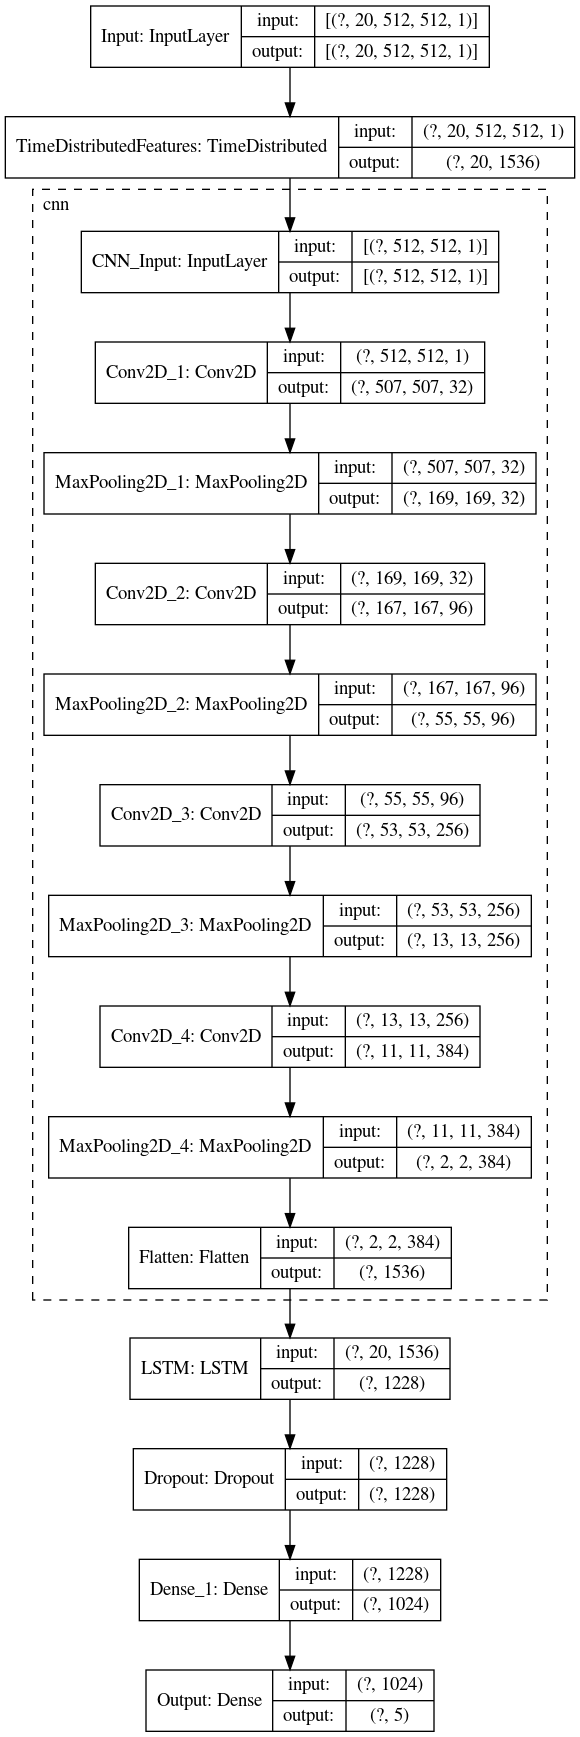

In [3]:
model = build_model(image_dims=(512,512,1), n_slices=20) 
model.summary() 

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True) 

## 3. Training the model:

The first thing we have to do is separate our data into a training set and a testing set. The training set will be used to train the model, while the testing set will be used to validate the trained model. A frequent split is 70/30, so that 70% of our data is used for training, while the remaining 30% is used for testing. Out of the training data, 20% is usually be separated to do validation during training, to ensure we are not overfitting our model.

We already created an .h5 file with 3 separate datasets (training, validation and testing) with the processed data. The CT scans are the *X_* sets, and the GOLD scores are the *y_* ones. 

_The .h5 file provided with the files of this project contains a small subsample of the file we used to train our model, with only 175 CT scans (50 for training, 25 for validation and 100 for testing). This file is meant to be used as an example to understand how .h5 files work and to have a sample of the data used for the project._

In [4]:
train_h5 = 'BDSubmission_COPDStaging.h5'
h5f      = h5py.File(train_h5, 'r') 

X_train = h5f['X_train'] 
y_train = h5f['y_train'] 
X_val   = h5f['X_val'] 
y_val   = h5f['y_val'] 
X_test  = h5f['X_test'] 
y_test  = h5f['y_test'] 

print('Training images:  ', X_train.shape, '\tTraining labels:  ', y_train.shape)  
print('Validation images:', X_val.shape,   '\tValidation labels:', y_val.shape)  
print('Testing images:   ', X_test.shape,  '\tTesting labels:   ', y_test.shape) 

Training images:   (1500, 20, 512, 512, 1) 	Training labels:   (1500,)
Validation images: (150, 20, 512, 512, 1) 	Validation labels: (150,)
Testing images:    (4081, 20, 512, 512, 1) 	Testing labels:    (4081,)


We did not follow the 70/30 split of the data. This is because we wanted to have balanced training and validation sets, and we wanted to keep the training process relatively short. If we display the distribution of GOLD scores in each set, we can see that each class has the same amount of points in both the training and validation sets, while the testing set has an uneven distribution.

In [5]:
# Calculate and display the distribution of each GOLD score in each set:
g0_train = np.sum(np.asarray(y_train)==0.) / len(y_train) * 100
g1_train = np.sum(np.asarray(y_train)==1.) / len(y_train) * 100
g2_train = np.sum(np.asarray(y_train)==2.) / len(y_train) * 100
g3_train = np.sum(np.asarray(y_train)==3.) / len(y_train) * 100
g4_train = np.sum(np.asarray(y_train)==4.) / len(y_train) * 100
g0_val = np.sum(np.asarray(y_val)==0.) / len(y_val) * 100
g1_val = np.sum(np.asarray(y_val)==1.) / len(y_val) * 100
g2_val = np.sum(np.asarray(y_val)==2.) / len(y_val) * 100
g3_val = np.sum(np.asarray(y_val)==3.) / len(y_val) * 100
g4_val = np.sum(np.asarray(y_val)==4.) / len(y_val) * 100
g0_test = np.sum(np.asarray(y_test)==0.) / len(y_test) * 100
g1_test = np.sum(np.asarray(y_test)==1.) / len(y_test) * 100
g2_test = np.sum(np.asarray(y_test)==2.) / len(y_test) * 100
g3_test = np.sum(np.asarray(y_test)==3.) / len(y_test) * 100
g4_test = np.sum(np.asarray(y_test)==4.) / len(y_test) * 100

print('           | GOLD 0 | GOLD 1 | GOLD 2 | GOLD 3 | GOLD 4') 
print('-----------+--------+--------+--------+--------+--------')
print('TRAIN      |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%%' % 
      (g0_train, g1_train, g2_train, g3_train, g4_train)) 
print('VALIDATION |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%%' % 
      (g0_val,   g1_val,   g2_val,   g3_val,   g4_val)) 
print('TEST       |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%% |  %4.1f%%' % 
      (g0_test,  g1_test,  g2_test,  g3_test,  g4_test)) 

           | GOLD 0 | GOLD 1 | GOLD 2 | GOLD 3 | GOLD 4
-----------+--------+--------+--------+--------+--------
TRAIN      |  20.0% |  20.0% |  20.0% |  20.0% |  20.0%
VALIDATION |  20.0% |  20.0% |  20.0% |  20.0% |  20.0%
TEST       |  51.4% |   6.4% |  25.8% |  13.3% |   3.2%


To speed up the training process and save up memory, we will use generators to feed the CT scans and labels to our model. Tensorflow has a native class named ImageDataGenerator, but unfortunately it only works with 2D images, and we are working with 3D volumes. To work around this problem, we will build a custom generator. 

Our generator inherits the tensorflow _Sequence_ class, so we only have to customize a few of its methods, everything else is already coded for us. The inputs of our generator as as follows:
- **list_IDs**: list. A list of integers corresponding to the .h5 indexes of the data to use
- **x_dataset**: HDF5 dataset. Input CTs dataset to use (*X_train, X_val, X_test*)
- **y_dataset_name**: HDF5 dataset. Input GOLD scores dataset to use (*y_train, y_val, y_test*)
- **batch_size**: integer. Amount of data points (*X,y*) to retrieve at reach iteration
- **dim**: tuple. Volume size
- **n_channes**: integer. Number of channels
- **n_classes**: integer. Number of classes
- **shuffle**: boolean. Whether or not to shuffle the data
- **return_label**: boolean. Whether or not to return the *y* values

In [7]:
from tensorflow import keras 

class DataGenerator(tf.keras.utils.Sequence):
    """Data generator for 3D volumes"""
    
    def __init__(self, list_IDs, x_dataset, y_dataset, batch_size=7, dim=(20,512,512), n_channels=1,
                 n_classes=5, shuffle=True, return_label=True):
        self.x_dataset    = x_dataset
        self.y_dataset    = y_dataset
        self.dim          = dim
        self.batch_size   = batch_size
        self.list_IDs     = list_IDs
        self.n_channels   = n_channels
        self.n_classes    = n_classes
        self.shuffle      = shuffle
        self.return_label = return_label
        self.on_epoch_end()          

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size)) 

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch:
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] 

        # Find list of IDs:
        list_IDs_temp = [self.list_IDs[k] for k in indexes] 

        # Generate data:
        X, y = self.__data_generation(list_IDs_temp) 
        
        if self.return_label == True: #training and validation
            return X, y
        else:                         #testing
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs)) 
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization:
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) 
        y = np.empty((self.batch_size))  

        # Generate data:
        for i, ID in enumerate(list_IDs_temp):
            # Store image sample:
            X[i,] = self.x_dataset[ID] 
            # Store label sample:
            y[i,] = self.y_dataset[ID]  

        return X, y 

You can read more about custom image generators here: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

We build a generator for training data, another one for validation data and a last one for testing data. The test generator will not return the labels, as in the testing phase we only need the volumes to make predicitons on. It will also not shuffle the data, as this will allow us to match the predictions to the ground truth scores.

In [8]:
train_generator      = DataGenerator(np.arange(0,len(y_train)), X_train, y_train)  
validation_generator = DataGenerator(np.arange(0,len(y_val)),   X_val,   y_val)  
test_generator       = DataGenerator(np.arange(0,len(y_test)),  X_test,  y_test, return_label=False, shuffle=False) 

We can run our training and testing generators to ensure that they are working as needed:

(7, 20, 512, 512, 1)


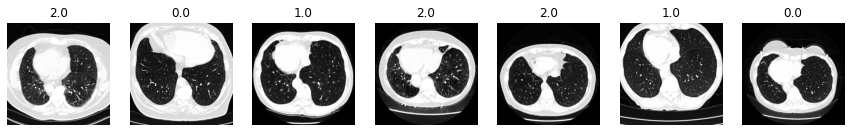

(7, 20, 512, 512, 1)


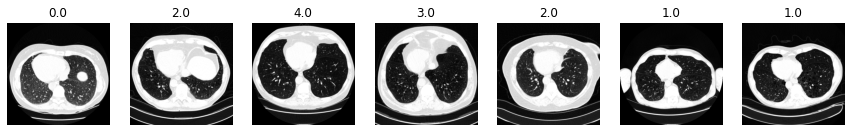

(7, 20, 512, 512, 1)


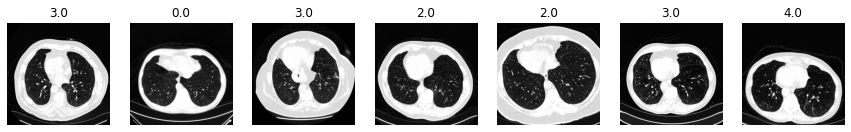

(7, 20, 512, 512, 1)


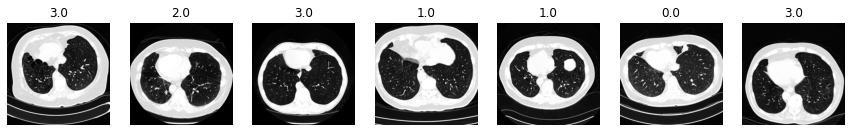

(7, 20, 512, 512, 1)


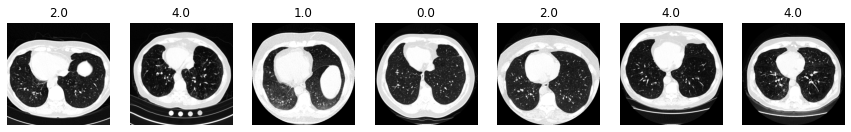

In [9]:
# The train generator should return batches of 7 CT scans, each containing 20 slices of dimension 512x512x1,
# as well as the associated GOLD score for each scan:
for ii in range(5):
    _tmp = train_generator.__getitem__(0)  
    xx = _tmp[0] 
    yy = _tmp[1] 
    print(xx.shape) 
    cnt = 0
    plt.figure(figsize=(15,12)) 
    for img in xx:
        plt.subplot(1,7,cnt+1) 
        plt.axis('off') 
        plt.title(yy[cnt]) 
        plt.imshow(img[5,:,:], cmap='gray') 
        cnt += 1
    plt.show() 
    train_generator.on_epoch_end() 

(7, 20, 512, 512, 1)


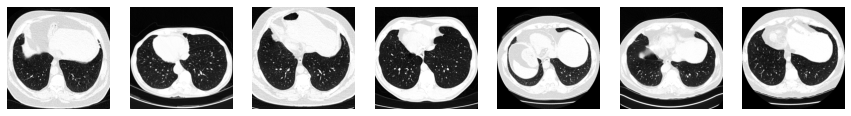

(7, 20, 512, 512, 1)


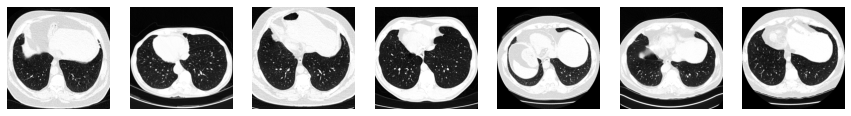

(7, 20, 512, 512, 1)


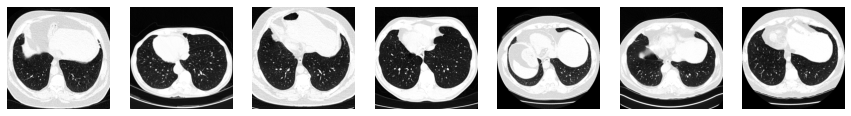

(7, 20, 512, 512, 1)


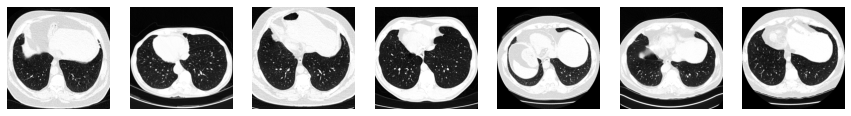

(7, 20, 512, 512, 1)


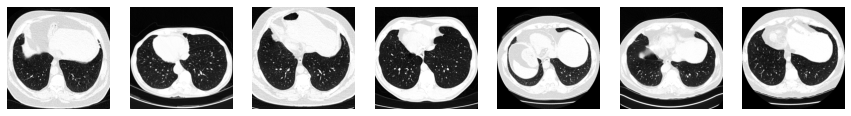

In [10]:
# The test generator should return batches of 7 CT scans like the train generator, but it should not return
# the associated GOLD scores:
for ii in range(5):
    _tmp = test_generator.__getitem__(0)  
    xx = _tmp
    print(xx.shape) 
    cnt = 0
    plt.figure(figsize=(15,12)) 
    for img in xx:
        plt.subplot(1,7,cnt+1) 
        plt.axis('off') 
        plt.imshow(img[5,:,:], cmap='gray') 
        cnt += 1
    plt.show() 
    test_generator.on_epoch_end() 

To train the model, we first have to compile it, specifying both the loss and the optimizer function to use. As we are working on a multiclass classification problem, with each class labeled as a unique integer number, and each class being exclusive (for example, a subject cannot be classified as being both GOLD 1 and GOLD 3), we will use *sparse categorical crossentropy* as our loss funciton. To better gauge the performance of he model as it is being trained, our trainer will also compute the accuracy after each epoch.

In [11]:
model.compile(loss      = 'sparse_categorical_crossentropy',
              optimizer = Adam(lr=1e-5),
              metrics   = ['sparse_categorical_accuracy']) 

We can now train our model on our data. We will make use of *callbacks*, which allow us to have more control over the training process. <br>
 - *ModelCheckpoint* will save the model each time the validation accuracy improves, so we can later save the best model (and not the latest, which might have overfitted the training data).
 - *EartlyStopping* will stop the training process when the validation accuracy has not improved in the last 7 epochs.
 - *ReduceLROnPlateau* will decrease the learning rate when the validation loss has not improved in the last 3 epochs.

Due to memory constraints, and because we are working with large volumes, the higest batch size we can use to train the model is 7. 

In [10]:
model_checkpoint = ModelCheckpoint('./BDSubmission_models/Untitled Folder 5/model-epoch{epoch:03d}.h5', verbose=1, 
                                   monitor='val_sparse_categorical_accuracy', save_best_only=True, mode='max')  
earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=7, verbose=0, mode='max') 
reduceLR  = ReduceLROnPlateau(monitor='val_loss',                        patience=3, verbose=1, mode='min') 


history = model.fit(train_generator, 
                    shuffle='batch',
                    batch_size=7, 
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint, earlyStopping, reduceLR]) 

print('\n\nTraining ended.')

Epoch 1/100
214/214 [==============================] - ETA: 0s - loss: 1.6118 - sparse_categorical_accuracy: 0.1876
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.21769, saving model to ./BDSubmission_models/Untitled Folder 5/model-epoch001.h5
214/214 [==============================] - 443s 2s/step - loss: 1.6118 - sparse_categorical_accuracy: 0.1876 - val_loss: 1.6068 - val_sparse_categorical_accuracy: 0.2177 - lr: 1.0000e-05
Epoch 2/100
214/214 [==============================] - ETA: 0s - loss: 1.6089 - sparse_categorical_accuracy: 0.2210
Epoch 00002: val_sparse_categorical_accuracy improved from 0.21769 to 0.24490, saving model to ./BDSubmission_models/Untitled Folder 5/model-epoch002.h5
214/214 [==============================] - 252s 1s/step - loss: 1.6089 - sparse_categorical_accuracy: 0.2210 - val_loss: 1.6034 - val_sparse_categorical_accuracy: 0.2449 - lr: 1.0000e-05
Epoch 3/100
214/214 [==============================] - ETA: 0s - loss: 1.6034 - sparse_cate

We can analyze the training process by plotting the loss and the accuracy of our model at each epoch:

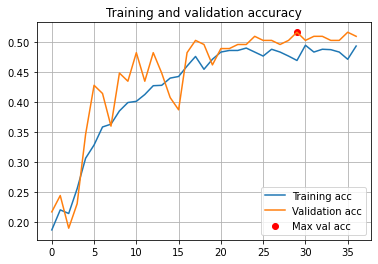

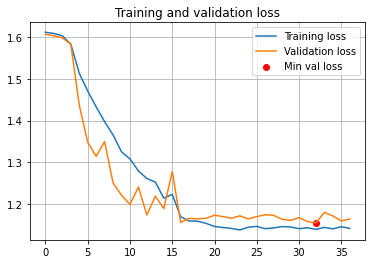

In [11]:
### Plot training results:
b_acc      = history.history['sparse_categorical_accuracy'] 
b_val_acc  = history.history['val_sparse_categorical_accuracy'] 
loss       = history.history['loss'] 
val_loss   = history.history['val_loss'] 

min_val_loss = (np.argmin(val_loss),  np.min(val_loss)) 
max_val_acc  = (np.argmax(b_val_acc), np.max(b_val_acc)) 
epochs       = range(len(b_acc)) 

plt.plot(epochs, b_acc,                     label='Training acc') 
plt.plot(epochs, b_val_acc,                 label='Validation acc') 
plt.scatter(max_val_acc[0], max_val_acc[1], label='Max val acc', color='r', marker='o') 
plt.title('Training and validation accuracy')         
plt.legend() 
plt.grid() 

plt.figure() 

plt.plot(epochs, loss,                        label='Training loss') 
plt.plot(epochs, val_loss,                    label='Validation loss') 
plt.scatter(min_val_loss[0], min_val_loss[1], label='Min val loss', color='r', marker='o') 
plt.title('Training and validation loss')  
plt.legend() 
plt.grid() 

plt.show() 

## 4. Testing the trained model:

We will load the best model (the model that achieved the lowest validation loss during training), and use it to predict the GOLD scores of our testing set.

In [12]:
#Load best model:
model_file = 'model-epoch030.h5'
model_path = os.path.join(os.getcwd(), 'BDSubmission_models', model_file)  
model      = build_model(image_dims=(512,512,1), n_slices=20) 
model.load_weights(model_path) 

In [13]:
# Make predictions using the testing generator:
predictions = model.predict(test_generator, batch_size=7, verbose=1) 

583/583 [==============================] - 921s 2s/step


We can compare the predictions of our model with the ground truth GOLD scores. We should notice that the ground truth GOLD score of any given CT volume is a single number from 0 to 4, while the predicted GOLD score is a vector of 5 probabilities, each one corresponding to one of the GOLD values (the first element of the vector is the probability that the CT volume is a GOLD 0, the second element is the probability of the volume of being GOLD 1 and so on).<br><br>
We can also calculate the predicted class by retrieving the index of the highest probability, as we know that each index corresponds to a GOLD score.

In [14]:
# Load the HDF5 object as a numpy array to read and edit it:
y_test = np.asarray(y_test) 
print('Ground truth shape:    ', y_test.shape) 
print('Predicted scores shape:', predictions.shape) 

print('\nGround truth of the first 5 CTs:') 
print(y_test[:5]) 
print('\nPredicted probabilities of the first 5 CTs:') 
print(predictions[:5]) 
print('\nPredicted score of the first 5 CTs:') 
print(np.argmax(predictions[:5], axis=-1)) 

Ground truth shape:     (4081,)
Predicted scores shape: (4081, 5)

Ground truth of the first 5 CTs:
[0. 0. 0. 0. 0.]

Predicted probabilities of the first 5 CTs:
[[2.1350732e-01 2.8428307e-01 3.2276124e-01 1.2952350e-01 4.9924843e-02]
 [5.1786590e-01 3.8746631e-01 7.9888359e-02 1.2262380e-02 2.5170597e-03]
 [4.0570837e-01 2.6802287e-01 2.4178329e-01 6.3807666e-02 2.0677835e-02]
 [5.9772241e-01 3.5698342e-01 4.0732309e-02 4.0014437e-03 5.6041230e-04]
 [4.7353584e-01 2.4619088e-01 2.1112731e-01 5.2819785e-02 1.6326185e-02]]

Predicted score of the first 5 CTs:
[2 0 0 0 0]


We can manually calculate the overall accuracy of our model:

In [15]:
cnt = 0
for ii in np.arange(0,len(predictions)):
    if np.argmax(predictions[ii]) == y_test[ii]:
        cnt += 1
    
print('Total number of matches:', cnt, '/', ii+1) 
print('Percentage of correct matches: %.2f%%' % (100*(cnt/(ii+1)))) 

Total number of matches: 2244 / 4081
Percentage of correct matches: 54.99%


Or we can use *Scikit learn* to compute it. *Scikit learn* also has a function that calculates the balanced accuracy, which is the weighted accuracy across all clases. This is a better metric for unbalanced sets, as a classificator might be really good at predicting one class but fail when predicting another.

In [16]:
acc   = accuracy_score(y_test, np.argmax(predictions, axis=-1))
b_acc = balanced_accuracy_score(y_test, np.argmax(predictions, axis=-1)) 
print('Accuracy:          %.2f%%' % (100*acc)) 
print('Balanced accuracy: %.2f%%' % (100*b_acc)) 

Accuracy:          54.99%
Balanced accuracy: 43.99%


We can also calculate the accuracy of each class, separatedly:

In [20]:
cnt_g_0 = 0   # Gold 0) 
cnt_g_1 = 0   # positive COPD diagnosis (Gold 1) 
cnt_g_2 = 0   # positive COPD diagnosis (Gold 2) 
cnt_g_3 = 0   # positive COPD diagnosis (Gold 3) 
cnt_g_4 = 0   # positive COPD diagnosis (Gold 4) 

for ii in np.arange(0,len(predictions)):
    if np.argmax(predictions[ii]) == y_test[ii]:
        if y_test[ii] == 0:
            cnt_g_0 += 1
        elif y_test[ii] == 1:
            cnt_g_1 += 1
        elif y_test[ii] == 2:
            cnt_g_2 += 1
        elif y_test[ii] == 3:
            cnt_g_3 += 1
        elif y_test[ii] == 4:
            cnt_g_4 += 1
    
true_g_0 = np.sum(y_test==0) 
true_g_1 = np.sum(y_test==1) 
true_g_2 = np.sum(y_test==2) 
true_g_3 = np.sum(y_test==3) 
true_g_4 = np.sum(y_test==4) 

print('Gold 0: %4d / %4d \t (%5.2f%%)' % (cnt_g_0, true_g_0, 100*(cnt_g_0/true_g_0))) 
print('Gold 1: %4d / %4d \t (%5.2f%%)' % (cnt_g_1, true_g_1, 100*(cnt_g_1/true_g_1))) 
print('Gold 2: %4d / %4d \t (%5.2f%%)' % (cnt_g_2, true_g_2, 100*(cnt_g_2/true_g_2))) 
print('Gold 3: %4d / %4d \t (%5.2f%%)' % (cnt_g_3, true_g_3, 100*(cnt_g_3/true_g_3))) 
print('Gold 4: %4d / %4d \t (%5.2f%%)' % (cnt_g_4, true_g_4, 100*(cnt_g_4/true_g_4))) 

Gold 0: 1615 / 2097 	 (77.01%)
Gold 1:   56 /  260 	 (21.54%)
Gold 2:  335 / 1053 	 (31.81%)
Gold 3:  160 /  541 	 (29.57%)
Gold 4:   78 /  130 	 (60.00%)


*Scikit learn* has a method that automatically calculates some of the most frequently used classification metrics, such as the precision and the accuracy. We can use it to display a report of the performance of our model on the testing set.

In [21]:
report = classification_report(y_test, np.argmax(predictions, axis=-1), target_names=index, zero_division=0)
print(report)  

              precision    recall  f1-score   support

      GOLD 0       0.74      0.77      0.76      2097
      GOLD 1       0.13      0.22      0.16       260
      GOLD 2       0.43      0.32      0.37      1053
      GOLD 3       0.40      0.30      0.34       541
      GOLD 4       0.25      0.60      0.35       130

    accuracy                           0.55      4081
   macro avg       0.39      0.44      0.40      4081
weighted avg       0.56      0.55      0.55      4081



Another good metric to calculate when working on classification problems is the confusion matrix. *Scikit learn* has a method that computes it automatically, and you can plot it with using Seaborn. In the example below, we normalized the values of the confusion matrix by the true label (the sum of each row is equal to 100), so we can see which percentage of the data was correctly classified, as well as the percentages of data that were incorrectly classified into the remaining classes. 

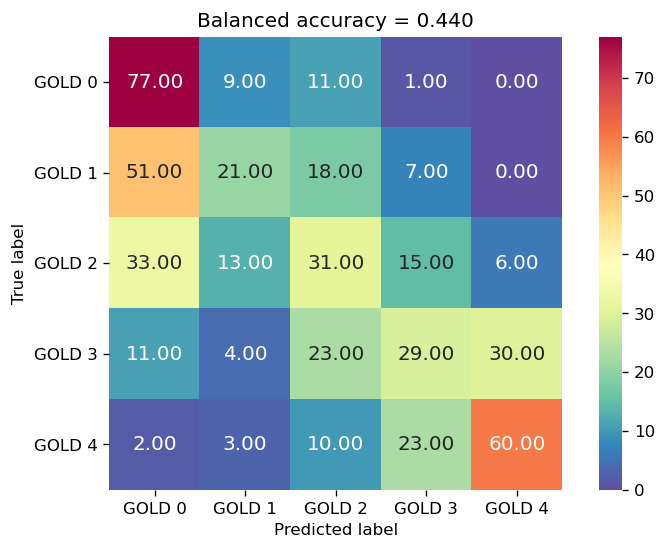

In [18]:
c_m   = confusion_matrix(y_test, np.argmax(predictions, axis=-1)) 
index = ['GOLD 0', 'GOLD 1', 'GOLD 2', 'GOLD 3', 'GOLD 4'] 

# Normalize the confusion matrix by true label:
c_m[0,:] = c_m[0,:] / len(y_test[y_test==0]) * 100
c_m[1,:] = c_m[1,:] / len(y_test[y_test==1]) * 100
c_m[2,:] = c_m[2,:] / len(y_test[y_test==2]) * 100
c_m[3,:] = c_m[3,:] / len(y_test[y_test==3]) * 100
c_m[4,:] = c_m[4,:] / len(y_test[y_test==4]) * 100
cm_df = pd.DataFrame(c_m,
                     index  =index,
                     columns=index)  

plt.figure(figsize=(8, 5), dpi=120)  
sns.heatmap(cm_df, annot=True, annot_kws={"size": 12}, fmt='.2f', cmap='Spectral_r', square=True)#cmap="coolwarm")  
plt.ylabel('True label') 
plt.xlabel('Predicted label') 
plt.title('Balanced accuracy = {:.3f}'.format(b_acc)) 
plt.yticks(rotation=0) 
plt.show() 

ROC curves allow us to measure the sensitivity and specificity of our classifier, and let us compute the AUC (area under the curve) which gives a measure of the performance of our model. They are most frequently used for binary classifiers, but we can adjust our data to be able to calculate them.

DCNN: AUC ROC = 0.777
- Gold 0: 0.825
- Gold 1: 0.639
- Gold 2: 0.672
- Gold 3: 0.840
- Gold 4: 0.906


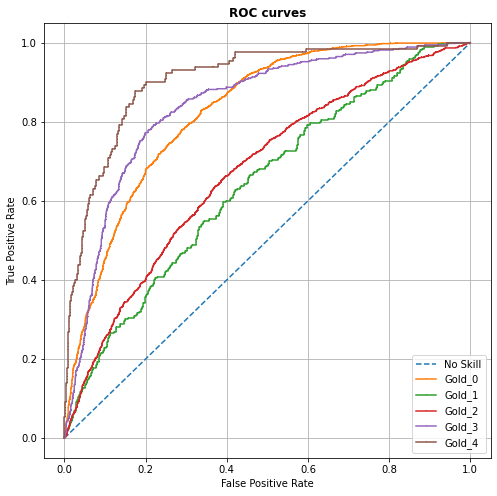

In [23]:
# Keep probabilities for the positive outcomes only and calcuate the AUC score:
lr_probs = np.copy(predictions) 
lr_auc   = roc_auc_score(y_test[:], lr_probs, multi_class='ovr')  
print('DCNN: AUC ROC = %.3f' % (lr_auc)) 

# Compute the AUC ROC for each of the GOLD scores:
lr_auc   = roc_auc_score(np.eye(5)[y_test.astype(int)][:,0], lr_probs[:,0])  
print('- Gold 0: %.3f' % (lr_auc)) 
lr_auc   = roc_auc_score(np.eye(5)[y_test.astype(int)][:,1], lr_probs[:,1])  
print('- Gold 1: %.3f' % (lr_auc)) 
lr_auc   = roc_auc_score(np.eye(5)[y_test.astype(int)][:,2], lr_probs[:,2])  
print('- Gold 2: %.3f' % (lr_auc)) 
lr_auc   = roc_auc_score(np.eye(5)[y_test.astype(int)][:,3], lr_probs[:,3])  
print('- Gold 3: %.3f' % (lr_auc)) 
lr_auc   = roc_auc_score(np.eye(5)[y_test.astype(int)][:,4], lr_probs[:,4])  
print('- Gold 4: %.3f' % (lr_auc)) 

# Calculate and plot the ROC curves:
ns_fpr,   ns_tpr,   _ = roc_curve(np.eye(5)[y_test.astype(int)][:,0], np.zeros(len(y_test))) 
lr_fpr_0, lr_tpr_0, _ = roc_curve(np.eye(5)[y_test.astype(int)][:,0], lr_probs[:,0]) 
lr_fpr_1, lr_tpr_1, _ = roc_curve(np.eye(5)[y_test.astype(int)][:,1], lr_probs[:,1]) 
lr_fpr_2, lr_tpr_2, _ = roc_curve(np.eye(5)[y_test.astype(int)][:,2], lr_probs[:,2]) 
lr_fpr_3, lr_tpr_3, _ = roc_curve(np.eye(5)[y_test.astype(int)][:,3], lr_probs[:,3]) 
lr_fpr_4, lr_tpr_4, _ = roc_curve(np.eye(5)[y_test.astype(int)][:,4], lr_probs[:,4]) 

plt.figure(figsize=(8,8)) 
plt.plot(ns_fpr,   ns_tpr,   linestyle='--', label='No Skill') 
plt.plot(lr_fpr_0, lr_tpr_0, marker=',',     label='Gold_0') 
plt.plot(lr_fpr_1, lr_tpr_1, marker=',',     label='Gold_1') 
plt.plot(lr_fpr_2, lr_tpr_2, marker=',',     label='Gold_2') 
plt.plot(lr_fpr_3, lr_tpr_3, marker=',',     label='Gold_3') 
plt.plot(lr_fpr_4, lr_tpr_4, marker=',',     label='Gold_4') 
plt.grid() 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC curves', fontweight='bold')
plt.legend() 
plt.show() 

Lastly, we can plot the probability distribution of each class, to gain a better understanding of the confidence of the predictions of our model.

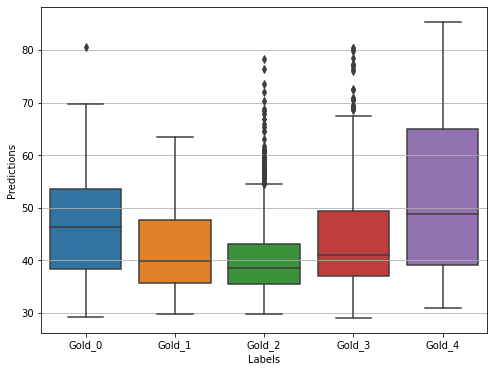

GOLD 0:  perc25 = 38.321   perc75 = 53.520
GOLD 1:  perc25 = 35.573   perc75 = 47.695
GOLD 2:  perc25 = 35.523   perc75 = 43.100
GOLD 3:  perc25 = 36.904   perc75 = 49.432
GOLD 4:  perc25 = 39.152   perc75 = 65.038


In [22]:
labels = []
for ii in np.arange(0,len(lr_probs)):
    if y_test[ii] == 0:
        labels.append('Gold_0') 
    elif y_test[ii] == 1:
        labels.append('Gold_1') 
    elif y_test[ii] == 2:
        labels.append('Gold_2') 
    elif y_test[ii] == 3:
        labels.append('Gold_3') 
    elif y_test[ii] == 4:
        labels.append('Gold_4') 
        
idx_max       = np.expand_dims(np.argmax(lr_probs, axis=1), -1) 
curated_preds = np.take_along_axis(lr_probs, idx_max, axis=1).squeeze()  
df = pd.DataFrame({'Predictions': 100*curated_preds,
                   'Labels': labels}) 

# Plot the probability distribution of each class:
plt.figure(figsize=(8,6)) 
plt.grid() 
sns.boxplot(x='Labels', y='Predictions', data= df, order=['Gold_0', 'Gold_1', 'Gold_2', 'Gold_3', 'Gold_4']) 
plt.show() 

ll  = df['Labels']=='Gold_0'
p_0 = df['Predictions'][ll==True] 
ll  = df['Labels']=='Gold_1'
p_1 = df['Predictions'][ll==True] 
ll  = df['Labels']=='Gold_2'
p_2 = df['Predictions'][ll==True] 
ll  = df['Labels']=='Gold_3'
p_3 = df['Predictions'][ll==True] 
ll  = df['Labels']=='Gold_4'
p_4 = df['Predictions'][ll==True] 

print('GOLD 0:  perc25 = %.3f   perc75 = %.3f' % (np.percentile(p_0, 25), np.percentile(p_0, 75))) 
print('GOLD 1:  perc25 = %.3f   perc75 = %.3f' % (np.percentile(p_1, 25), np.percentile(p_1, 75))) 
print('GOLD 2:  perc25 = %.3f   perc75 = %.3f' % (np.percentile(p_2, 25), np.percentile(p_2, 75))) 
print('GOLD 3:  perc25 = %.3f   perc75 = %.3f' % (np.percentile(p_3, 25), np.percentile(p_3, 75))) 
print('GOLD 4:  perc25 = %.3f   perc75 = %.3f' % (np.percentile(p_4, 25), np.percentile(p_4, 75))) 